In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import json
import numpy as np
import uuid
from matplotlib import pyplot as plt
import glob
from PIL import Image

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[]

# DATA_LOADING

In [3]:
# Define the path of the folder containing the images
folder_path = 'aug_data\\val\\images_2'

# Loop through all the files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image file
    if filename.endswith('.jpg'):
        # Open the image file
        image = Image.open(os.path.join(folder_path, filename))
        
        # Convert the image to greyscale
        greyscale_image = image.convert('L')
        
        # Save the greyscale image in the same folder with the same name
        greyscale_image.save(os.path.join(folder_path, filename))

In [4]:
# Define the path of the folder containing the images
folder_path = 'aug_data\\train\\images'

# Loop through all the files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image file
    if filename.endswith('.jpg'):
        # Open the image file
        image = Image.open(os.path.join(folder_path, filename))
        
        # Convert the image to greyscale
        greyscale_image = image.convert('L')
        
        # Save the greyscale image in the same folder with the same name
        greyscale_image.save(os.path.join(folder_path, filename))

In [5]:
# Define the path of the folder containing the images
folder_path = 'aug_data\\test\\images'

# Loop through all the files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image file
    if filename.endswith('.jpg'):
        # Open the image file
        image = Image.open(os.path.join(folder_path, filename))
        
        # Convert the image to greyscale
        greyscale_image = image.convert('L')
        
        # Save the greyscale image in the same folder with the same name
        greyscale_image.save(os.path.join(folder_path, filename))

In [2]:
# image_loading
def load_image(x):
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    return img

In [3]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250, 250)))
train_images = train_images.map(lambda x: x/255)

In [8]:
test_images = tf.data.Dataset.list_files('aug_data\\test_2\\images\\*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250, 250)))
test_images = test_images.map(lambda x: x/255)

In [9]:
val_images = tf.data.Dataset.list_files('aug_data\\val_2\\images\\*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250, 250)))
val_images = val_images.map(lambda x: x/255)

In [10]:
train_images.as_numpy_iterator().next()

array([[[0.46039218],
        [0.4602353 ],
        [0.46509802],
        ...,
        [0.12235294],
        [0.12360782],
        [0.11843137]],

       [[0.464     ],
        [0.456     ],
        [0.4564706 ],
        ...,
        [0.10509804],
        [0.11074501],
        [0.11215686]],

       [[0.45960784],
        [0.4407843 ],
        [0.42352942],
        ...,
        [0.10588235],
        [0.10509799],
        [0.12156863]],

       ...,

       [[0.7058824 ],
        [0.7058824 ],
        [0.70980394],
        ...,
        [0.627451  ],
        [0.627451  ],
        [0.6313726 ]],

       [[0.7058824 ],
        [0.7058824 ],
        [0.70980394],
        ...,
        [0.63450974],
        [0.6384313 ],
        [0.63450974]],

       [[0.7176471 ],
        [0.7176471 ],
        [0.7176471 ],
        ...,
        [0.63529414],
        [0.63529414],
        [0.6313726 ]]], dtype=float32)

# label_prep

In [11]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return[label['keypoints']]

In [12]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [13]:
iterator = train_labels.as_numpy_iterator()

In [14]:
iterator.next()

(array([0.699 , 0.626 , 0.8154, 0.6216], dtype=float16),)

In [15]:
test_labels = tf.data.Dataset.list_files('aug_data\\test_2\\labels\\*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [16]:
val_labels = tf.data.Dataset.list_files('aug_data\\val_2\\labels\\*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [17]:
val_labels.as_numpy_iterator().next()

(array([0.2319, 0.4146, 0.1578, 0.4465], dtype=float16),)

In [18]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3040, 3040, 1000, 1000, 1000, 1000)

In [19]:
# Combining labels and images
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(8000)
train = train.batch(16)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(16)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(16)
val = val.prefetch(4)

In [20]:
train.as_numpy_iterator().next()[1]

(array([[0.494 , 0.563 , 0.3948, 0.5493],
        [0.    , 0.    , 0.    , 0.    ],
        [0.563 , 0.3984, 0.    , 0.    ],
        [0.626 , 0.5454, 0.723 , 0.5454],
        [0.4753, 0.3875, 0.3647, 0.3977],
        [0.    , 0.    , 0.    , 0.    ],
        [0.5425, 0.5645, 0.62  , 0.6006],
        [0.507 , 0.4355, 0.4338, 0.4915],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2654, 0.3547, 0.1492, 0.374 ],
        [0.852 , 0.6123, 0.9287, 0.5713],
        [0.589 , 0.38  , 0.6616, 0.4358],
        [0.546 , 0.5576, 0.6597, 0.5215],
        [0.516 , 0.448 , 0.417 , 0.4617],
        [0.79  , 0.5815, 0.866 , 0.5405]], dtype=float16),)

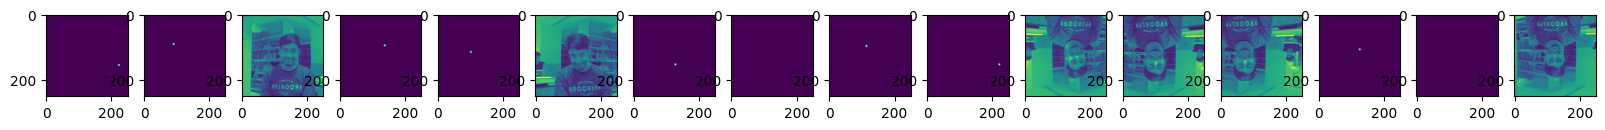

In [21]:
# Viewing samples
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols = 16, figsize = (20, 20))
for idx in range(16):
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    # Red circle is left eye
    # Blue circle is R eye
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 3, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 3, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [21]:
# # Building the model

# model = Sequential([
#     Input(shape = (250, 250, 3)),
#     ResNet152V2(include_top = False, input_shape = (250, 250, 3)),
#     Conv2D(512, 3, padding = 'same', activation = 'relu'),
#     Conv2D(512, 3, padding = 'same', activation = 'relu'),
#     Conv2D(256, 3, 2, padding = 'same', activation = 'relu'),
#     Conv2D(256, 2, 2, activation = 'ReLU'),
#     Dropout(0.05),
#     Conv2D(4,2,2),
#     Reshape((4,))
# ])

In [22]:
# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(250, 250, 1)),
#     tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)),
#     tf.keras.applications.ResNet152V2(
#         include_top=False,
#         weights="imagenet",
#         input_shape=(250, 250, 3),  # Change the input shape to (250, 250, 3)
#         pooling=None,
#     ),
#     tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu"),
#     tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu"),
#     tf.keras.layers.Conv2D(256, 3, strides=2, padding="same", activation="relu"),
#     tf.keras.layers.Conv2D(256, 2, strides=2, activation="relu"),
#     tf.keras.layers.Dropout(0.05),
#     tf.keras.layers.Conv2D(4, 2, strides=2),
#     tf.keras.layers.Reshape((4,)),
# ])

In [23]:
# GRAY_SCALE MODEL
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(250, 250, 1)),
    tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)),
    tf.keras.layers.Conv2D(3, (3, 3), padding='same'),
    tf.keras.applications.ResNet152V2(
        include_top=False,
        weights="imagenet",
        input_shape=(250, 250, 3),
        pooling=None,
    ),
    tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(256, 3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(256, 2, strides=2, activation="relu"),
    tf.keras.layers.Dropout(0.05),
#     Dropout  = 0.6
#     use batch normalization
#     early stopping 
    
    tf.keras.layers.Conv2D(4, 2, strides=2),
    tf.keras.layers.Reshape((4,))
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 3)       84        
                                                                 
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 256)         2

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, weight_decay = 0.0007)
loss = tf.keras.losses.MeanSquaredError()


In [26]:
model.compile(optimizer,loss)

In [27]:
X, y = train.as_numpy_iterator().next()

In [28]:
X.shape

(16, 250, 250, 1)

In [29]:
coordinates = model.predict(X)
coordinates

1/1 [==============================] - 4s 4s/step


array([[ 0.3584835 ,  0.72228014, -0.21461001, -0.28183812],
       [ 0.00962473,  0.14019163, -0.15673539, -0.09384093],
       [-0.01811615,  0.31542143, -1.2182378 , -0.09539443],
       [-0.2414425 ,  0.6985421 , -0.6209751 ,  0.34298015],
       [ 0.2320486 ,  0.9775889 , -0.24911436, -0.67507255],
       [ 0.2130639 ,  1.0147884 , -0.9033699 , -0.33394462],
       [-0.4923242 ,  0.11908716, -0.49313307, -0.5837558 ],
       [ 0.0103157 ,  0.6706997 , -0.37089807, -0.3836491 ],
       [-0.01822016,  0.7442059 , -0.23634794, -0.41836396],
       [-0.07738838,  0.77023536,  0.17985095, -0.69024783],
       [ 0.6472869 ,  0.44210285,  0.09395066, -0.4025277 ],
       [ 0.4056384 ,  0.37539813, -0.9430961 , -0.5626223 ],
       [-0.12894367, -0.31238362, -0.32798165, -0.44100237],
       [-0.57119715,  0.21899885, -0.96110845, -0.91341007],
       [ 0.7101546 ,  1.1658309 , -0.20954446, -0.9287524 ],
       [ 0.09577066,  0.6086635 , -0.07198137, -0.2731387 ]],
      dtype=float32)

In [30]:
# Model_training
hist = model.fit(train, epochs = 10, validation_data = val)
# Actual number of epochs is 100

Epoch 1/10
190/190 [==============================] - 1800s 9s/step - loss: 1.3346 - val_loss: 0.0199
Epoch 2/10
190/190 [==============================] - 1739s 9s/step - loss: 0.0285 - val_loss: 0.0313
Epoch 3/10
190/190 [==============================] - 1745s 9s/step - loss: 0.0189 - val_loss: 0.0718
Epoch 4/10
190/190 [==============================] - 1766s 9s/step - loss: 0.0157 - val_loss: 0.0109
Epoch 5/10
190/190 [==============================] - 1949s 10s/step - loss: 0.0114 - val_loss: 0.0362
Epoch 6/10
190/190 [==============================] - 1756s 9s/step - loss: 0.0092 - val_loss: 0.1186
Epoch 7/10
190/190 [==============================] - 1834s 10s/step - loss: 0.0069 - val_loss: 0.0037
Epoch 8/10
190/190 [==============================] - 1953s 10s/step - loss: 0.0059 - val_loss: 0.0064
Epoch 9/10
190/190 [==============================] - 1811s 10s/step - loss: 0.0054 - val_loss: 0.0592
Epoch 10/10
190/190 [==============================] - 1955s 10s/step - loss: 

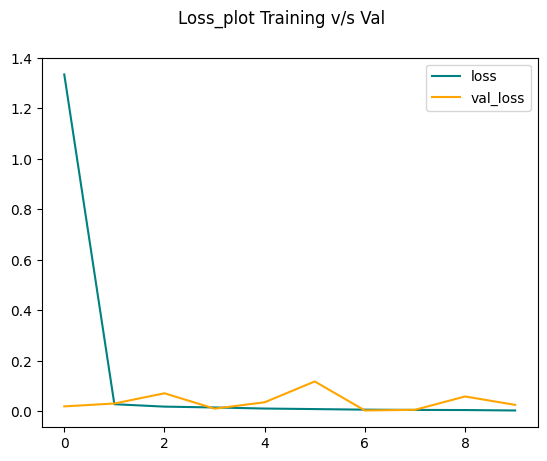

In [42]:
# Reviewing the performance
hist.history
# Plotting the losses and evaluating the model
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
plt.suptitle('Loss_plot Training v/s Val')
plt.legend()
plt.show()

In [2]:
test_data = test.as_numpy_iterator()

NameError: name 'test' is not defined

In [1]:
test_sample = test_data.next()

NameError: name 'test_data' is not defined

In [34]:
yhat = model.predict((test_sample[0]))

1/1 [==============================] - 2s 2s/step


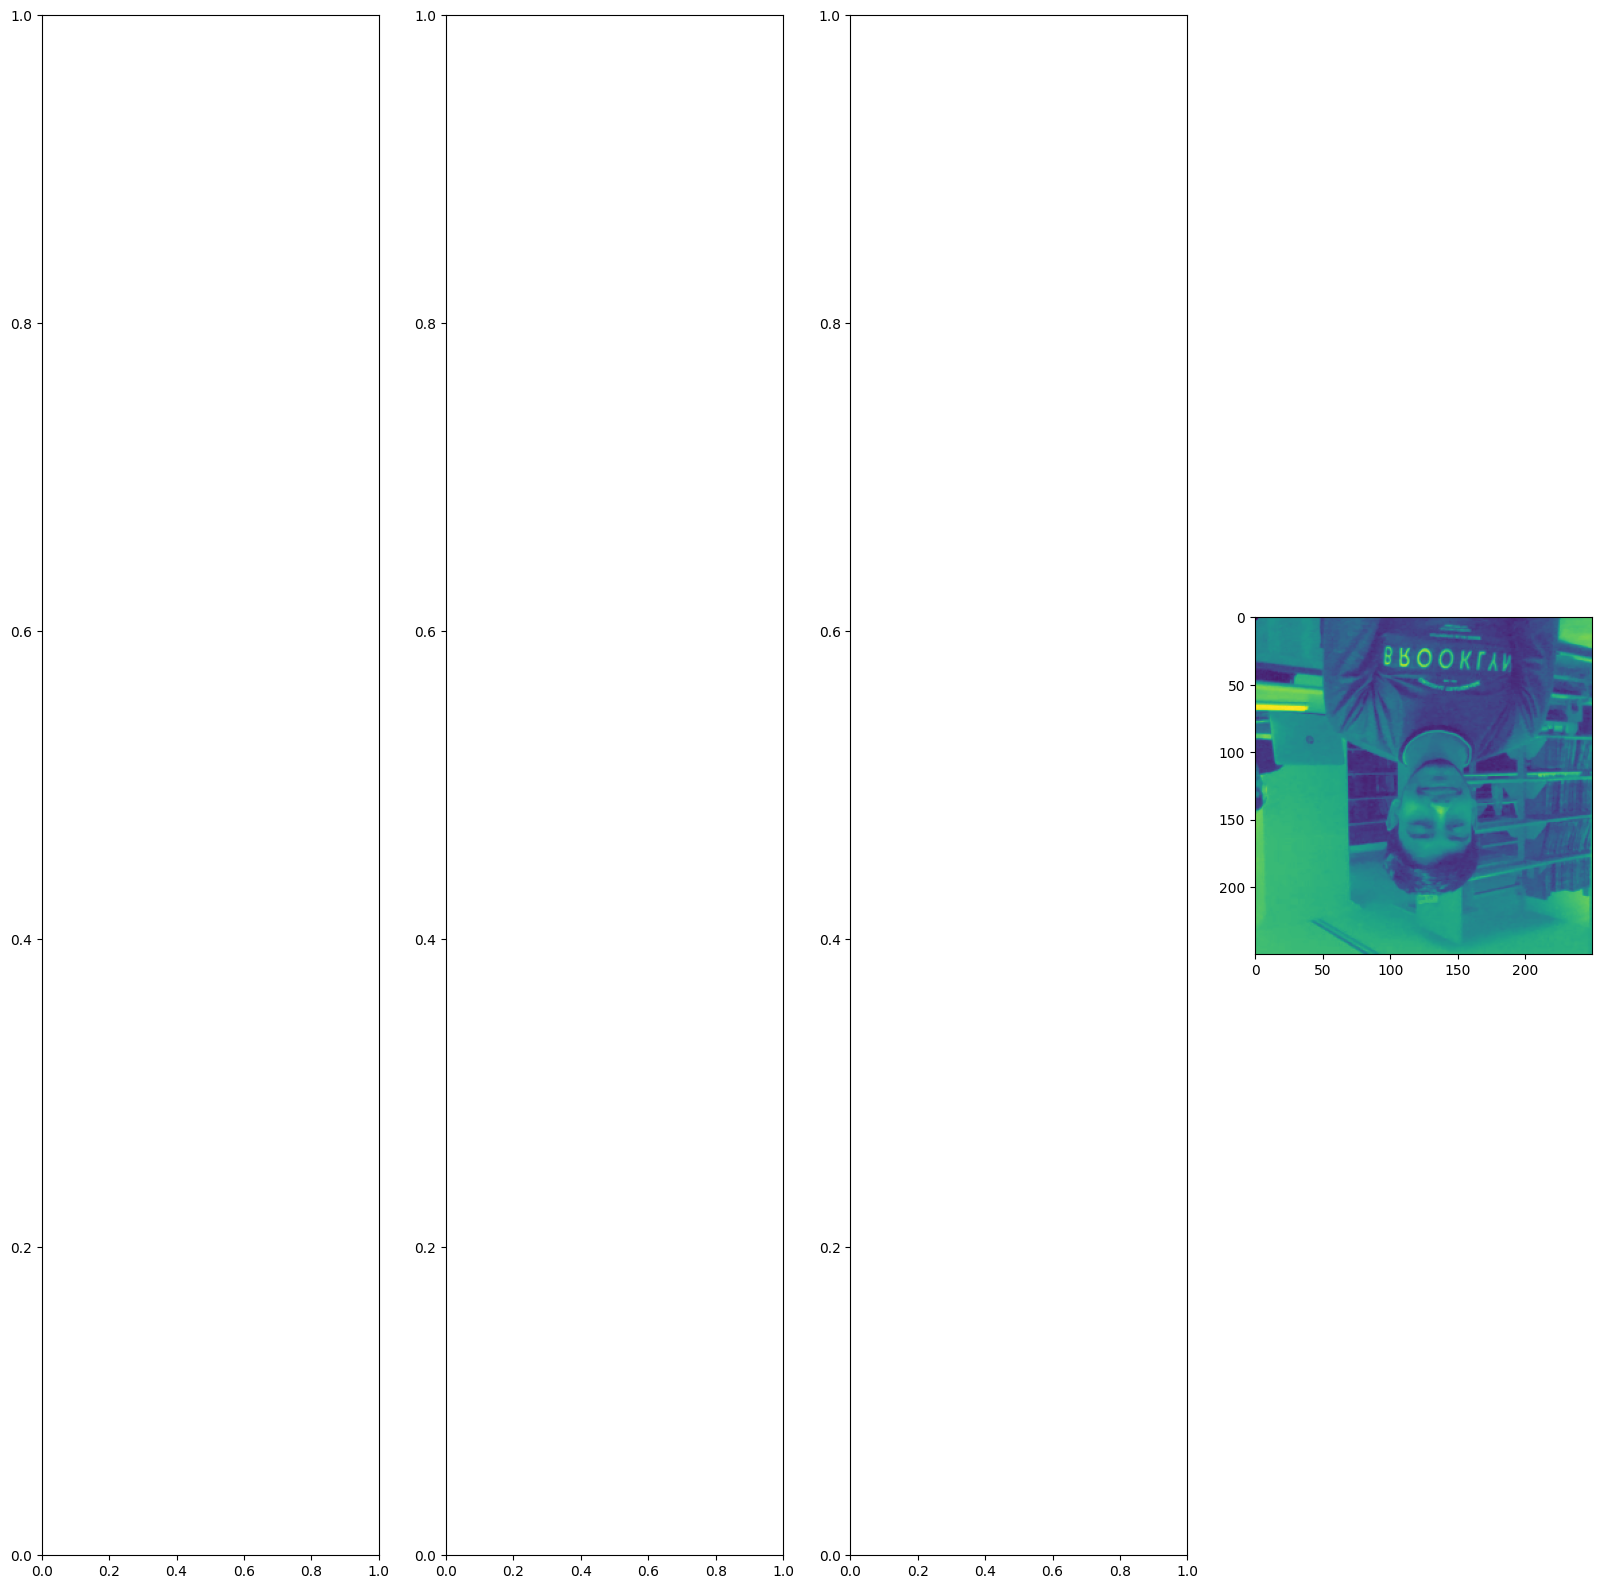

In [35]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
# Red circle is left eye
# Blue circle is R eye
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
ax[idx].imshow(sample_image)

In [46]:
# Saving the model
from tensorflow.keras.models import load_model
model.save('iris_detection_model_10_epoch_final')


INFO:tensorflow:Assets written to: iris_detection_model_10_epoch_final\assets


INFO:tensorflow:Assets written to: iris_detection_model_10_epoch_final\assets


In [2]:
from tensorflow.keras.models import load_model

In [5]:
model = load_model('iris_detection_model_100_epoch_final')

In [5]:
# predicting again with the same model after reloading
model.predict(test_sample[0])

NameError: name 'test_sample' is not defined

In [40]:
# # Real time detection 
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     _, frame = cap.read()
    
#     frame = frame[50:500, 50:500, :]
#     rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     resized = cv2.resize(rgb_img, (250, 250))
    
#     yhat = model.predict(np.expand_dims(resized/255, 0))
#     sample_coords = yhat[0,:4]
    
#     cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
#     cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
#     cv2.imshow('Eye_track', frame)
    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/lambda/grayscale_to_rgb/assert_equal_1/Assert/Assert' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1919, in _run_once
      handle._run()
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Arin\AppData\Local\Temp\ipykernel_47848\1675510226.py", line 10, in <module>
      yhat = model.predict(np.expand_dims(resized/255, 0))
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Arin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\layers\core\lambda_layer.py", line 210, in call
      result = self.function(inputs, **kwargs)
    File "C:/Users/Arin/AppData/Local/Temp/ipykernel_47848/1970404579.py", line 4, in <lambda>
Node: 'sequential/lambda/grayscale_to_rgb/assert_equal_1/Assert/Assert'
assertion failed: [Last dimension of a grayscale image should be size 1.] [Condition x == y did not hold element-wise:] [x (sequential/lambda/grayscale_to_rgb/strided_slice:0) = ] [3] [y (sequential/lambda/grayscale_to_rgb/assert_equal_1/y:0) = ] [1]
	 [[{{node sequential/lambda/grayscale_to_rgb/assert_equal_1/Assert/Assert}}]] [Op:__inference_predict_function_431797]

In [7]:
# GREY_SCALE CODE
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()

    # Crop the frame and convert it to grayscale
    cropped = frame[50:500, 50:500, :]
    gray_img = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

    # Resize the grayscale image
    resized = cv2.resize(gray_img, (250, 250))
    resized = np.expand_dims(resized, axis = -1)

    # Predict the coordinates using the model
    yhat = model.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[0, :4]

    # Draw circles on the original frame
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)

    # Show the frame
    cv2.imshow('Eye_track', frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 218ms/step


1/1 [==============================] - 0s 209ms/step


In [39]:
gray_img.shape

(430, 450)

In [40]:
resized.shape

(250, 250, 1)